In [2]:
from time import time

import numpy as np
import pandas as pd
import sys
sys.path.append('../../algorithms')
from SPOC import SPOC

from generate_SPOC_model import *
import matplotlib.pyplot as plt
import matplotlib
import matlab.engine

from tqdm import tqdm_notebook, tqdm
from IPython.display import clear_output, display
import random

%matplotlib inline
eng = matlab.engine.start_matlab()
_ = eng.addpath('../../algorithms')

# n_nodes
### Test with variable n_nodes

In [3]:
model = SPOC()

methods = {"SPOC": lambda A, n_clusters: model.fit(A=A, n_clusters=n_clusters, use_bootstrap=False, use_ellipsoid=False, use_cvxpy=False),
           "GeoNMF": lambda A, n_clusters: eng.GeoNMF(A, n_clusters, 0.25, 0.95, nargout=2),
           "SPOC_bootstrap": lambda A, n_clusters: model.fit(A=A, n_clusters=n_clusters, use_bootstrap=True, n_repetitions=10, std_num=3),
          }

In [4]:
n_clusters = 3
n_repetitions = 5
pn_number = n_clusters
random_vec = np.random.rand(3,)

EXP_DATA = pd.DataFrame(columns=["n_nodes", "n_clusters", "pure_nodes_number",\
                                 "seed", "method", "matrix", "error", "time"])

for n_nodes in tqdm_notebook(np.arange(1000, 5000, 500)):
    for repeat in tqdm_notebook(range(n_repetitions)):
        
        random.seed(repeat)
        np.random.seed(repeat)
        random_vec = 0.5 * np.random.rand(3,)
        B = np.diag([0.5] * 3 + random_vec)
        B = B / np.max(B)

        Theta = generate_theta(n_nodes=n_nodes, n_clusters=n_clusters, pure_nodes_number=pn_number, seed=repeat)
        P = Theta.dot(B).dot(Theta.T)
        A = P_to_A(P, seed=repeat)

        for method_name in methods: 
            if method_name == "GeoNMF":
                A = matlab.double(A.tolist())

            time_start = time()
            theta, b = methods[method_name](A, n_clusters)
            time_end = time()
            theta = np.array(theta)
            b = np.array(b)

            err, _ = find_permutation_Theta(Theta, theta)
            EXP_DATA = EXP_DATA.append({"n_nodes": n_nodes, "n_clusters": n_clusters,\
                                        "pure_nodes_number": pn_number, "seed":repeat,\
                                        "method":method_name, "matrix":"Theta", "error":err,\
                                        "time": time_end - time_start}, ignore_index=True)

            err, _ = find_permutation_B(B, b)
            EXP_DATA = EXP_DATA.append({"n_nodes": n_nodes, "n_clusters": n_clusters,\
                                        "pure_nodes_number": pn_number, "seed": repeat,\
                                        "method": method_name, "matrix": "B", "error": err,\
                                        "time": time_end - time_start}, ignore_index=True)

    EXP_DATA.to_csv("../../results/n_nodes.csv", index=None)

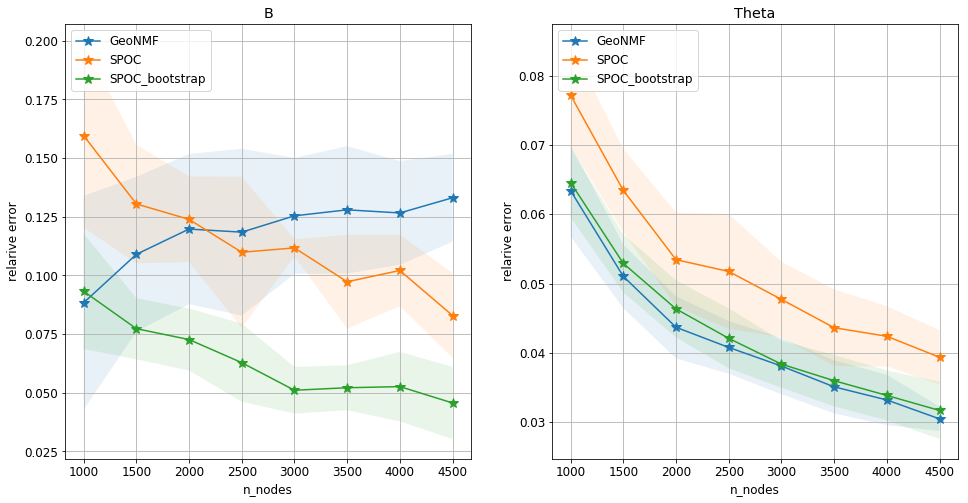

In [3]:
EXP_DATA = pd.read_csv("../../results/n_nodes.csv")

df = EXP_DATA.groupby(["n_nodes",  "method", "matrix"]).error.mean().reset_index()
std = EXP_DATA.groupby(["n_nodes",  "method", "matrix"]).error.std().reset_index()

fig = plt.figure(figsize=(16,8))
matplotlib.rcParams.update({'font.size': 12})

for method in df.method.unique():
    
    method_df = df[df["method"] == method]
    std_df = std[std["method"] == method]
    
    for num, matrix in enumerate(df.matrix.unique()):
        matrix_df = method_df[method_df["matrix"] == matrix]
        matrix_std = std_df[std_df["matrix"] == matrix]
        
        plt.subplot(1,2,num+1)
        plt.plot(matrix_df.n_nodes, matrix_df.error, label=method, marker='*', markersize=10)
        plt.fill_between(matrix_std.n_nodes, matrix_df.error - matrix_std.error, matrix_df.error + matrix_std.error,\
                         alpha=0.1)
        plt.xlabel("n_nodes")
        plt.ylabel("relarive error")
        plt.title(matrix)
        plt.legend(loc="upper left")
        plt.grid()
        #plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("../../pictures/n_nodes.png")

# alpha
### Test with variable alpha

In [13]:
n_nodes = 1000
rho = 0.7
n_clusters = 3
B = np.diag([0.4, 0.7, 1.])
n_repetitions = 10
pn_number = n_clusters

EXP_DATA = pd.DataFrame(columns=["n_nodes", "n_clusters", "pure_nodes_number", "alpha",\
                                 "seed", "method", "matrix", "error"])

for alpha in tqdm_notebook(np.arange(0.5, 4, 0.5)):
    
    for repeat in tqdm_notebook(range(n_repetitions)):
        Theta = generate_theta(n_nodes=n_nodes, n_clusters=n_clusters, pure_nodes_number=pn_number, \
                               seed=repeat, alphas=[alpha/n_clusters] * n_clusters)
        P = Theta.dot(B).dot(Theta.T)
        A = P_to_A(P, seed=repeat)
        
        A_mat = matlab.double(A.tolist())
        theta_geo, b_geo = eng.GeoNMF(A_mat, n_clusters, 0.25, 0.95, nargout=2)
        theta_geo = np.array(theta_geo)
        b_geo = np.array(b_geo)
        
        err, _ = find_permutation_Theta(Theta, theta_geo)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "alpha":alpha, "seed":repeat, "method":"Geo_NMF", "matrix":"Theta", "error":err}, ignore_index=True)
        err, _ = find_permutation_B(B, b_geo)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "alpha":alpha, "seed":repeat, "method":"Geo_NMF", "matrix":"B", "error":err}, ignore_index=True)
        
        model = SPOC()
        
        theta_spa, b_spa = model.fit(A=A, n_clusters=n_clusters, use_bootstrap=False, use_ellipsoid=False, use_cvxpy=False)
        err, _ = find_permutation_Theta(Theta, theta_spa)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "alpha":alpha, "seed":repeat, "method":"basic_SPA", "matrix":"Theta", "error":err}, ignore_index=True)
        err, _ = find_permutation_B(B, b_spa)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "alpha":alpha, "seed":repeat, "method":"basic_SPA", "matrix":"B", "error":err}, ignore_index=True)
        
        theta_bootstrap, b_bootstrap = model.fit(A=A, n_clusters=n_clusters, use_bootstrap=True, n_repetitions=300, std_num=3)
        err, _ = find_permutation_Theta(Theta, theta_bootstrap)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "alpha":alpha, "seed":repeat, "method":"bootstrap_SPA", "matrix":"Theta", "error":err}, ignore_index=True)
        err, _ = find_permutation_B(B, b_bootstrap)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "alpha":alpha, "seed":repeat, "method":"bootstrap_SPA", "matrix":"B", "error":err}, ignore_index=True)

EXP_DATA.to_csv("../../results/alphas.csv", index=None)

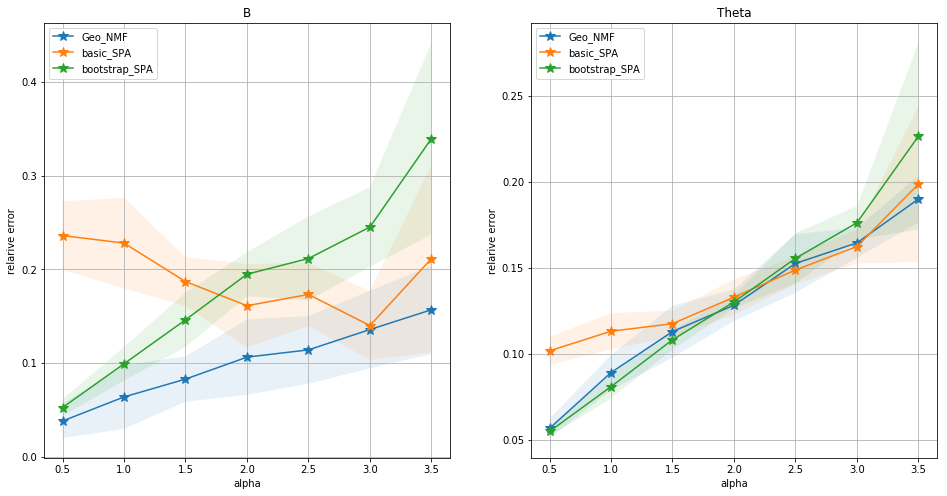

In [15]:
EXP_DATA = pd.read_csv("../../results/alphas.csv")
df = EXP_DATA.groupby(["alpha",  "method", "matrix"]).error.mean().reset_index()
std = EXP_DATA.groupby(["alpha",  "method", "matrix"]).error.std().reset_index()

plt.figure(figsize=(16,8))
for method in df.method.unique():
    method_df = df[df["method"] == method]
    std_df = std[std["method"] == method]
    
    for num, matrix in enumerate(df.matrix.unique()):
        matrix_df = method_df[method_df["matrix"] == matrix]
        matrix_std = std_df[std_df["matrix"] == matrix]
        
        plt.subplot(1,2,num+1)
        plt.plot(matrix_df.alpha, matrix_df.error, label=method, marker='*', markersize=10)
        plt.fill_between(matrix_std.alpha, matrix_df.error - matrix_std.error, matrix_df.error + matrix_std.error,\
                         alpha=0.1)
        plt.xlabel("alpha")
        plt.ylabel("relarive error")
        plt.title(matrix)
        plt.grid(0.3)
        plt.legend(loc="upper left")
plt.savefig("../../pictures/alphas.png")

# diagonal_off
### Test with non diagonal matrix

In [8]:
n_nodes = 1000
n_clusters = 3
Beta = np.array([0.6, 0.8, 1])
ones = np.ones((n_clusters, 1))
n_repetitions = 5
pn_number = n_clusters

EXP_DATA = pd.DataFrame(columns=["n_nodes", "n_clusters", "pure_nodes_number", "eps",\
                                 "seed", "method", "matrix", "error"])

for eps in np.arange(0.0, 0.45, 0.05):
    B = np.diag((Beta - eps * ones.T)[0]) + eps * np.dot(ones, ones.T)
    
    for repeat in tqdm_notebook(range(n_repetitions)):
        Theta = generate_theta(n_nodes=n_nodes, n_clusters=n_clusters, pure_nodes_number=pn_number, seed=repeat)
        P = Theta.dot(B).dot(Theta.T)
        A = P_to_A(P, seed=repeat)
        
        A_mat = matlab.double(A.tolist())
        theta_geo, b_geo = eng.GeoNMF(A_mat, n_clusters, 0.25, 0.95, nargout=2)
        theta_geo = np.array(theta_geo)
        b_geo = np.array(b_geo)
        
        err, _ = find_permutation_Theta(Theta, theta_geo)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "eps":eps, "seed":repeat, "method":"Geo_NMF", "matrix":"Theta", "error":err}, ignore_index=True)
        err, _ = find_permutation_B(B, b_geo)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "eps":eps, "seed":repeat, "method":"Geo_NMF", "matrix":"B", "error":err}, ignore_index=True)
        
        model = SPOC()
        
        theta_spa, b_spa = model.fit(A=A, n_clusters=n_clusters, use_bootstrap=False, use_ellipsoid=False, use_cvxpy=False)
        err, _ = find_permutation_Theta(Theta, theta_spa)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "eps":eps, "seed":repeat, "method":"basic_SPA", "matrix":"Theta", "error":err}, ignore_index=True)
        err, _ = find_permutation_B(B, b_spa)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "eps":eps, "seed":repeat, "method":"basic_SPA", "matrix":"B", "error":err}, ignore_index=True)
        
        theta_bootstrap, b_bootstrap = model.fit(A=A, n_clusters=n_clusters, use_bootstrap=True, n_repetitions=300, std_num=3)
        err, _ = find_permutation_Theta(Theta, theta_bootstrap)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "eps":eps, "seed":repeat, "method":"bootstrap_SPA", "matrix":"Theta", "error":err}, ignore_index=True)
        err, _ = find_permutation_B(B, b_bootstrap)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "eps":eps, "seed":repeat, "method":"bootstrap_SPA", "matrix":"B", "error":err}, ignore_index=True)

EXP_DATA.to_csv("../../results/off_diagonal.csv", index=None)

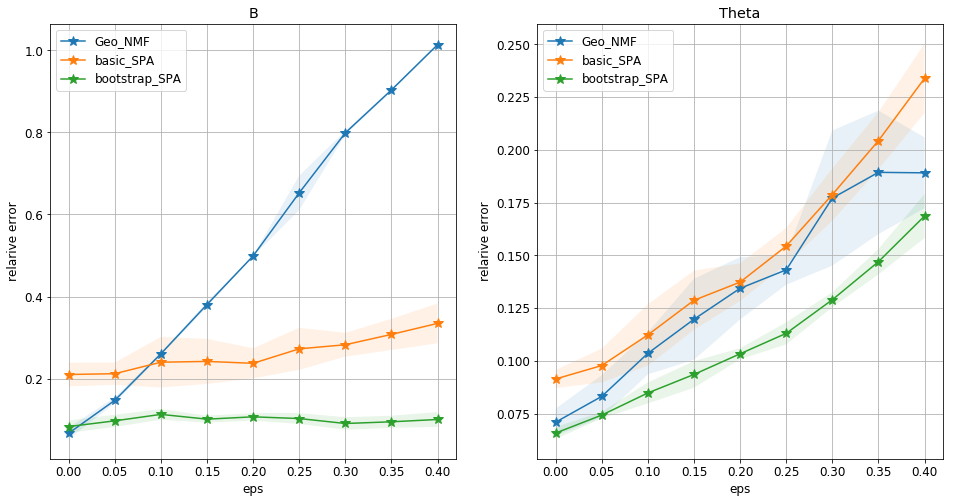

In [9]:
EXP_DATA = pd.read_csv("../../results/off_diagonal.csv")
df = EXP_DATA.groupby(["eps",  "method", "matrix"]).error.mean().reset_index()
std = EXP_DATA.groupby(["eps",  "method", "matrix"]).error.std().reset_index()

plt.figure(figsize=(16,8))
for method in df.method.unique():
    method_df = df[df["method"] == method]
    std_df = std[std["method"] == method]
    
    for num, matrix in enumerate(df.matrix.unique()):
        matrix_df = method_df[method_df["matrix"] == matrix]
        matrix_std = std_df[std_df["matrix"] == matrix]
        
        plt.subplot(1,2,num+1)
        plt.plot(matrix_df.eps, matrix_df.error, label=method, marker='*', markersize=10)
        plt.fill_between(matrix_std.eps, matrix_df.error - matrix_std.error, matrix_df.error + matrix_std.error,\
                         alpha=0.1)
        plt.xlabel("eps")
        plt.ylabel("relarive error")
        plt.title(matrix)
        plt.grid(0.3)
        plt.legend(loc="upper left")
plt.savefig("../../pictures/off_diagonal.png")

# skewness
### Test with variable skewness

In [11]:
n_nodes = 1000
n_clusters = 3
n_repetitions = 10
pn_number = n_clusters

EXP_DATA = pd.DataFrame(columns=["n_nodes", "n_clusters", "pure_nodes_number", "eps",\
                                 "seed", "method", "matrix", "error"])

for eps in np.arange(0.05, 0.5, 0.05):
    B = np.diag([0.5-eps, 0.5, 0.5+eps])
    B = B / np.max(B)
    
    for repeat in tqdm_notebook(range(n_repetitions)):
        Theta = generate_theta(n_nodes=n_nodes, n_clusters=n_clusters, pure_nodes_number=pn_number, seed=repeat)
        P = Theta.dot(B).dot(Theta.T)
        A = P_to_A(P, seed=repeat)
        
        A_mat = matlab.double(A.tolist())
        theta_geo, b_geo = eng.GeoNMF(A_mat, n_clusters, 0.25, 0.95, nargout=2)
        theta_geo = np.array(theta_geo)
        b_geo = np.array(b_geo)
        
        err, _ = find_permutation_Theta(Theta, theta_geo)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "eps":eps, "seed":repeat, "method":"Geo_NMF", "matrix":"Theta", "error":err}, ignore_index=True)
        err, _ = find_permutation_B(B, b_geo)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "eps":eps, "seed":repeat, "method":"Geo_NMF", "matrix":"B", "error":err}, ignore_index=True)
        
        model = SPOC()
        
        theta_spa, b_spa = model.fit(A=A, n_clusters=n_clusters, use_bootstrap=False, use_ellipsoid=False, use_cvxpy=False)
        err, _ = find_permutation_Theta(Theta, theta_spa)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "eps":eps, "seed":repeat, "method":"basic_SPA", "matrix":"Theta", "error":err}, ignore_index=True)
        err, _ = find_permutation_B(B, b_spa)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "eps":eps, "seed":repeat, "method":"basic_SPA", "matrix":"B", "error":err}, ignore_index=True)
        
        theta_bootstrap, b_bootstrap = model.fit(A=A, n_clusters=n_clusters, use_bootstrap=True, n_repetitions=300, std_num=3)
        err, _ = find_permutation_Theta(Theta, theta_bootstrap)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "eps":eps, "seed":repeat, "method":"bootstrap_SPA", "matrix":"Theta", "error":err}, ignore_index=True)
        err, _ = find_permutation_B(B, b_bootstrap)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "eps":eps, "seed":repeat, "method":"bootstrap_SPA", "matrix":"B", "error":err}, ignore_index=True)

EXP_DATA.to_csv("../../results/skewness.csv", index=None)

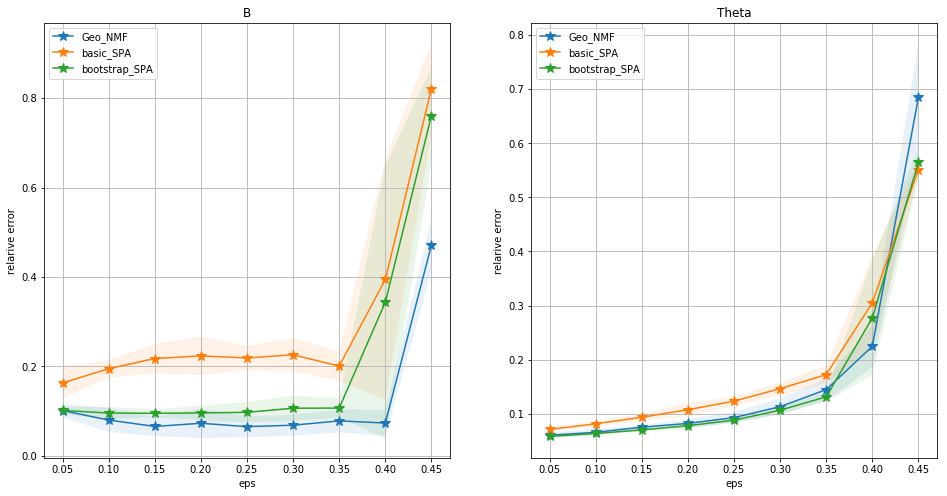

In [16]:
EXP_DATA = pd.read_csv("../../results/skewness.csv")
df = EXP_DATA.groupby(["eps",  "method", "matrix"]).error.mean().reset_index()
std = EXP_DATA.groupby(["eps",  "method", "matrix"]).error.std().reset_index()

plt.figure(figsize=(16,8))
for method in df.method.unique():
    method_df = df[df["method"] == method]
    std_df = std[std["method"] == method]
    
    for num, matrix in enumerate(df.matrix.unique()):
        matrix_df = method_df[method_df["matrix"] == matrix]
        matrix_std = std_df[std_df["matrix"] == matrix]
        
        plt.subplot(1,2,num+1)
        plt.plot(matrix_df.eps, matrix_df.error, label=method, marker='*', markersize=10)
        plt.fill_between(matrix_std.eps, matrix_df.error - matrix_std.error, matrix_df.error + matrix_std.error,\
                         alpha=0.1)
        plt.xlabel("eps")
        plt.ylabel("relarive error")
        plt.title(matrix)
        plt.grid(0.3)
        plt.legend(loc="upper left")
plt.savefig("../../pictures/skewness.png")